# Weather Forecasting

In [358]:
from warnings import filterwarnings
filterwarnings("ignore")

import os
import logging
import numpy as np
import pandas as pd
from zipfile import ZipFile
from datetime import datetime
import typing as tp

from IPython.display import display
from pylab import rcParams

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import TransformerMixin, RegressorMixin
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVR
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import register_matplotlib_converters
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
register_matplotlib_converters()

import statsmodels.api as sm
import pmdarima as pm
from tbats import TBATS
from xgboost import XGBRegressor

rcParams["figure.figsize"] = 15, 7

sns.set(palette = "Set2", font_scale = 1.3)

In [623]:
compare_table = None

def add_results_in_comparison_table(method: str, y_true, y_forecast) -> pd.DataFrame:
    
    global compare_table
    
    result_row = {
        'method': method,
        "MSE": mean_squared_error(y_true=y_true, y_pred=y_forecast),
        "MAE": mean_absolute_error(y_true=y_true, y_pred=y_forecast),
        "MAPE": mean_absolute_percentage_error(y_true=y_true, y_pred=y_forecast),
        'Median_error': median_absolute_error(y_true,y_forecast),
        'R^2' : r2(y_true,y_forecast)
    }
    
    # Записываем результат в таблицу
    if compare_table is None:
        compare_table = pd.DataFrame([result_row])
    else:
        if method in list(compare_table['method']):
            compare_table = compare_table[compare_table['method'] != method]

        compare_table = pd.concat([compare_table, pd.DataFrame([result_row])])
        compare_table.index = np.arange(len(compare_table))
    return compare_table

In [445]:
def plot_predictions(
    df_train, 
    df_test,
    target_train, 
    target_test, 
    y_pred, 
    plot_intervals=False, 
    scale=1.96, 
    plot_anomalies=False, 
    annot=''
):

    plt.figure(figsize = (15, 10))

    plt.subplot(2, 1, 1)
    plt.title(f'Temp predictions all {annot}')
    plt.plot(df_train.index, target_train, label = 'before', lw = 1)
    plt.plot(df_test.index, target_test, label = 'true test', lw = 1)
    plt.plot(df_test.index, y_pred, label = 'predicted test', lw = 1)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title(f'Temp predictions test {annot}')
    plt.plot(df_test.index, target_test, label = 'true test', lw = 1.5)
    plt.plot(df_test.index, y_pred, label = 'predicted test', lw = 1.5)
    plt.legend()

    if plot_intervals:
        mae = mean_absolute_error(target_test.values, y_pred)
        deviation = np.std(target_test.values - y_pred)
        lower_bond = y_pred - (mae + scale * deviation)
        upper_bond = y_pred + (mae + scale * deviation)
        plt.fill_between(df_test.index, lower_bond.squeeze(), upper_bond.squeeze(), color = 'green', alpha = 0.08)

        if plot_anomalies:
            anomalies = pd.DataFrame(index = target_test.index, columns = target_test.columns)
            anomalies[target_test<lower_bond] = target_test[target_test<lower_bond]
            anomalies[target_test>upper_bond] = target_test[target_test>upper_bond]
            plt.plot(anomalies, "o", markersize = 3, color = 'red')

In [6]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
!wget {uri}

zip_path = "jena_climate_2009_2016.csv.zip"
assert os.path.exists(zip_path), f"Download {uri}"

zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

--2023-04-30 22:46:42--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.162.128, 64.233.161.128, 64.233.165.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.162.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12,94M  10,5MB/s    in 1,2s    

2023-04-30 22:46:44 (10,5 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



In [576]:
zip_path = "jena_climate_2009_2016.csv.zip"
assert os.path.exists(zip_path), f"Download {uri}"

zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

Немного преобразуем данные, рассмотрев значение каждой величины за сутки:

In [577]:
weather_df = pd.read_csv(csv_path)
weather_df["Date"] = pd.to_datetime(weather_df["Date Time"], format="%d.%m.%Y %H:%M:%S")

In [578]:
weather_df_daily = weather_df.set_index("Date").resample('D').median().reset_index()
#del weather_df_daily["Date Time"]
weather_df_daily = weather_df_daily.set_index('Date')
weather_df_daily.tail()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date,,,,,,,,,,,,,,
2016-12-28,1013.680,4.950,277.030,2.375,83.20,8.70,7.250,1.470,4.460,7.15,1266.115,2.640,4.67,261.15
2016-12-29,1014.565,3.165,275.205,1.795,90.70,7.67,6.955,0.705,4.270,6.85,1275.425,0.740,1.38,207.10
2016-12-30,1010.755,-2.390,269.870,-3.205,96.35,5.12,4.820,0.170,2.975,4.77,1298.300,1.115,1.79,209.25
2016-12-31,1004.800,-3.845,269.165,-6.810,74.70,4.59,3.665,1.150,2.270,3.65,1293.460,0.805,1.44,198.35
2017-01-01,999.820,-4.820,268.360,-8.420,75.70,4.27,3.230,1.040,2.010,3.23,1296.380,1.230,1.96,184.90


Разделим данные на обучающие и тестовые. В качестве тестового отрезка времени возьмем данные за последний год. Обратим внимание, что за 2016-10-26 и 2016-10-27 данных нет.

In [579]:
insert_df = pd.concat([weather_df_daily.loc['2016-10-25', :], weather_df_daily.loc['2016-10-28', :]], axis = 1, ignore_index = False).transpose()
new_index = ['2016-10-26', '2016-10-27']
insert_df = insert_df.rename(index = dict(zip(insert_df.index, new_index)))

weather_df_daily = pd.concat(
                      [weather_df_daily.loc[weather_df_daily.index < '2016-10-26'],
                      insert_df,
                      weather_df_daily.loc[weather_df_daily.index > '2016-10-27']],
                      axis = 0
)

weather_df_daily.index = pd.to_datetime(weather_df_daily.index)

Выделим целевую переменную - погоду на завтра - в отдельный столбец:

In [580]:
weather_df_daily['Target'] = weather_df_daily['T (degC)'].shift(-1)
weather_df_daily.drop('2017-01-01', axis = 0, inplace = True)

In [581]:
def get_train_test_data(df, test_size):
    # TODO
    pass

In [605]:
test_size = 366
df_train = weather_df_daily.iloc[ : -test_size]
df_test = weather_df_daily.iloc[-test_size : ]

Визуализируем график температуры с годами:

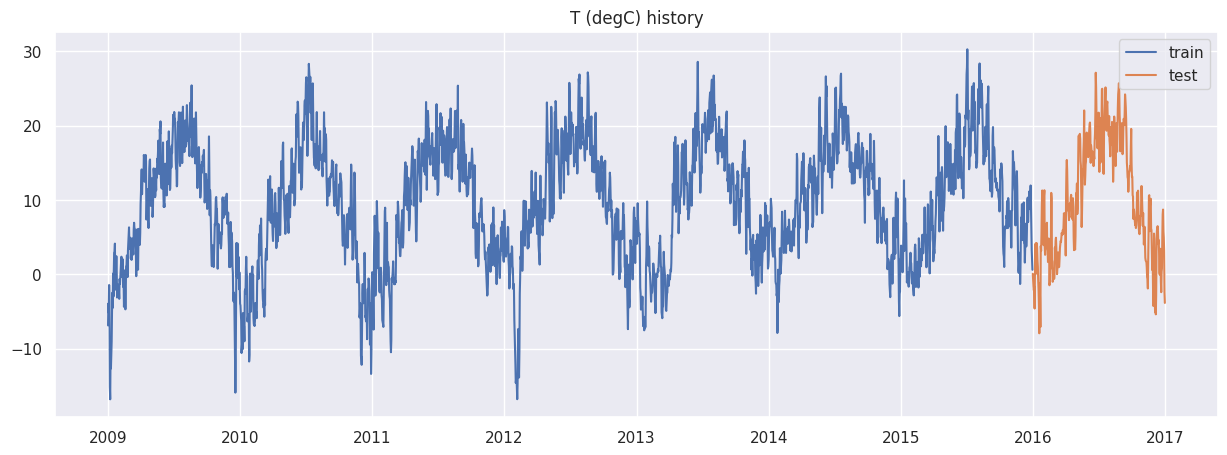

In [606]:
plt.figure(figsize = (15, 5))
plt.title("T (degC) history")
plt.plot(df_train.index, df_train['T (degC)'], label = 'train')
plt.plot(df_test.index, df_test['T (degC)'], label = 'test')
plt.legend();

In [607]:
target_train = df_train[['Target']]
target_test = df_test[['Target']]

Проведем простую аналитику:

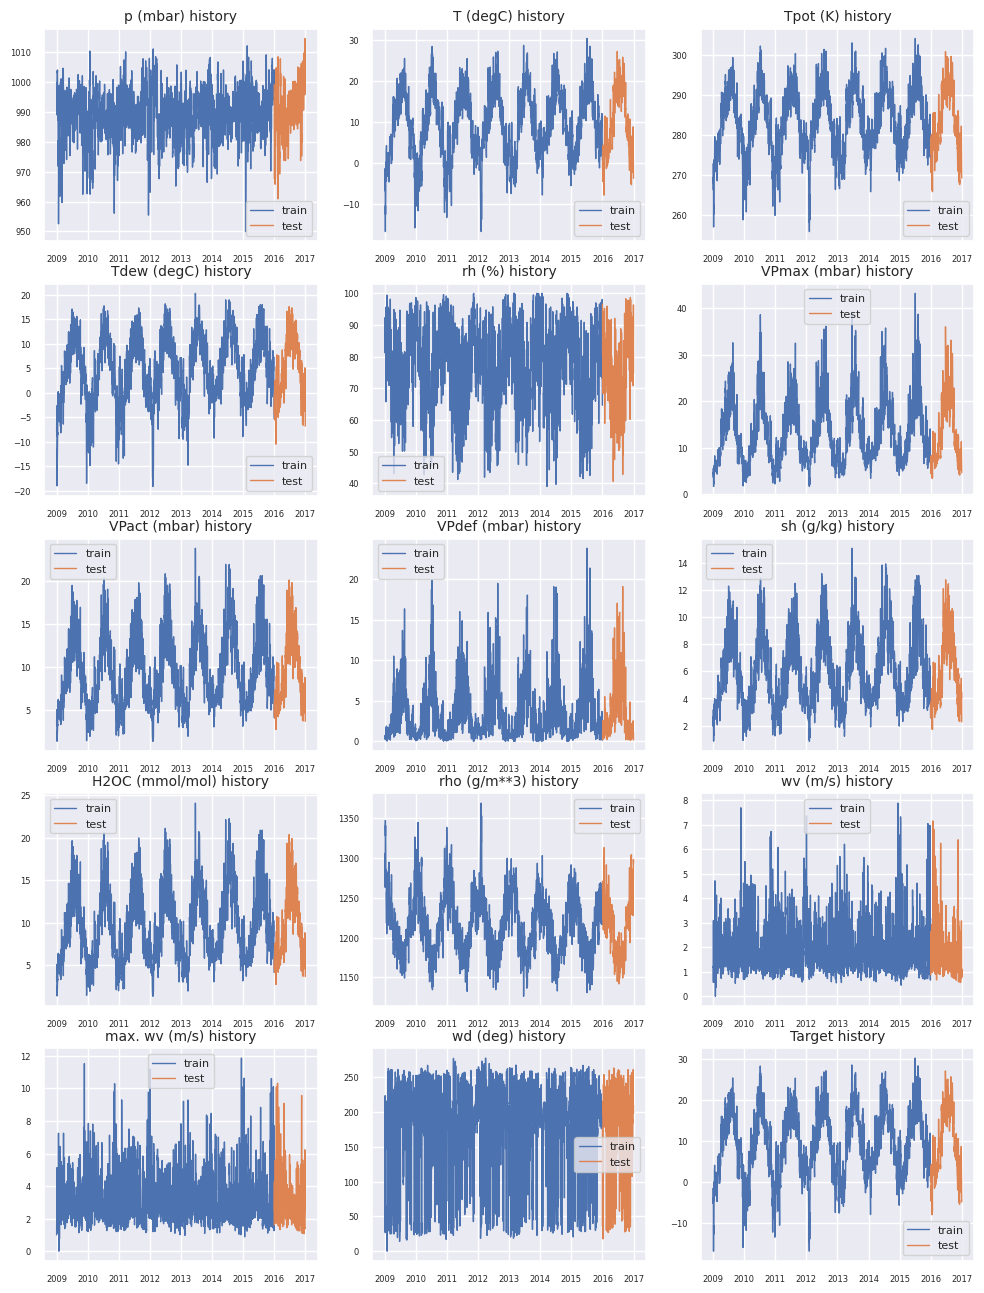

In [608]:
plt.figure(figsize = (12, 16))

for i, col in enumerate(df_train.columns):
    plt.subplot(5, 3, i + 1)
    plt.title(f"{col} history", fontsize = 10)
    plt.plot(df_train.index, df_train[col], label = 'train', lw = 1)
    plt.plot(df_test.index, df_test[col], label = 'test', lw = 1)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 6)
    plt.legend(fontsize = 8)

plt.show()

Видим, что в данных есть немного явных выбросов, разберемся с ними методом межквартильного размаха: *поскольку погода может резко меняться по некоторым паарметрам, то будем брать не 97\% доверительный интервал, а 99\%*:

In [609]:
alpha = 0.01
colums_bounds = dict()

for key in df_train.keys():
    vals = df_train[key].values
    colums_bounds[key] = np.quantile(vals, q = [alpha / 2, 1 - alpha / 2])

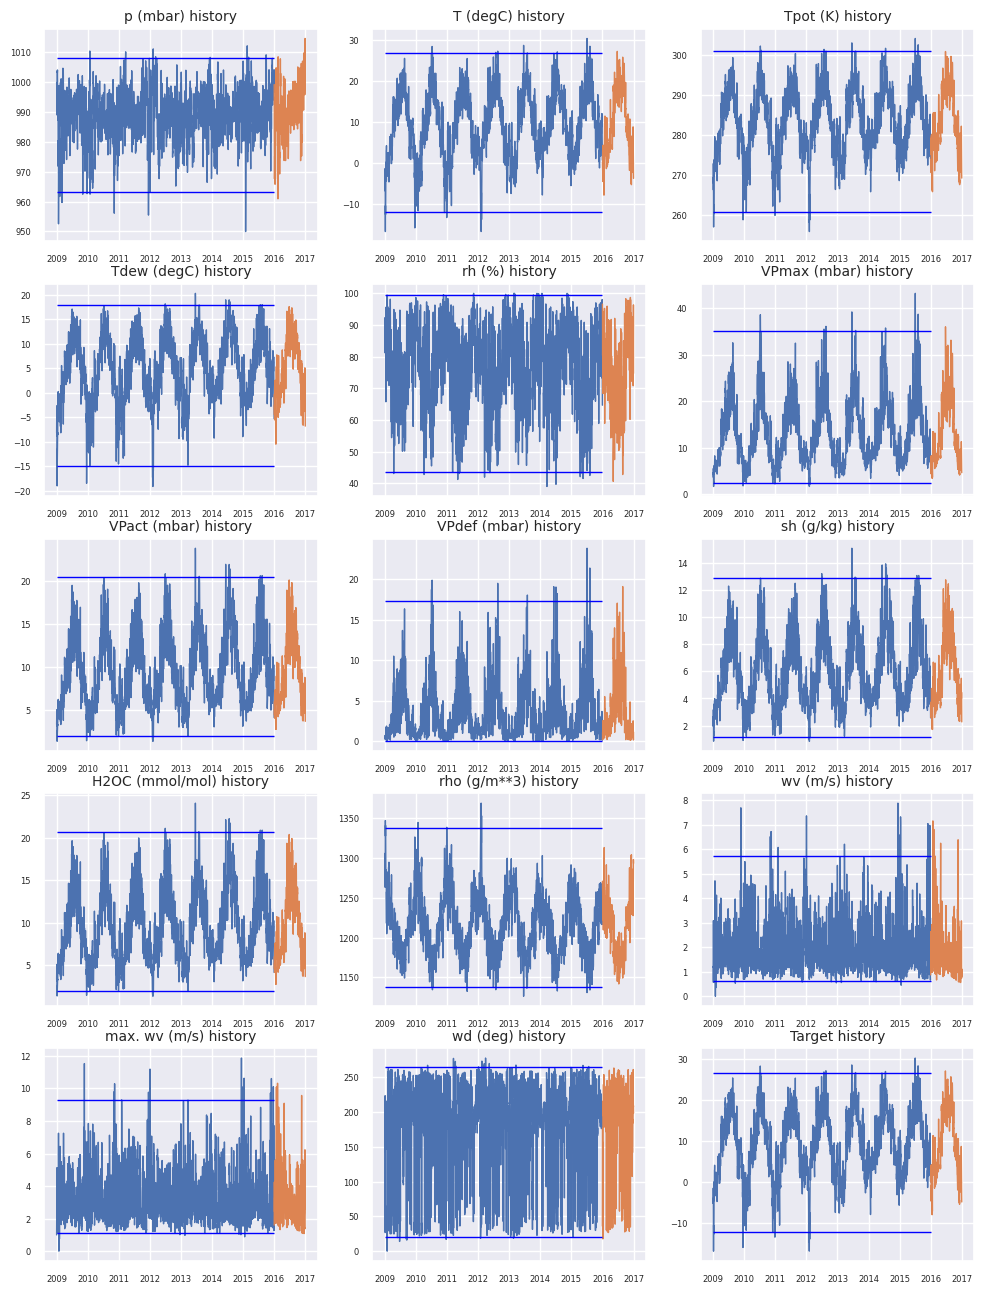

In [610]:
plt.figure(figsize = (12, 16))

for i, col in enumerate(df_train.columns):
    plt.subplot(5, 3, i + 1)
    plt.title(f"{col} history", fontsize = 10)
    plt.plot(df_train.index, df_train[col], label = 'train', lw = 1)
    plt.plot(df_test.index, df_test[col], label = 'test', lw = 1)
    plt.hlines(y=colums_bounds[col][0], xmin=df_train.index[0], xmax=df_train.index[-1], linewidth=2, color='blue', label='Down bound', lw = 1)
    plt.hlines(y=colums_bounds[col][1], xmin=df_train.index[0], xmax=df_train.index[-1], linewidth=2, color='blue', label='Up bound', lw = 1)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 6)

plt.show()

In [611]:
for key in df_train.keys():
    # change train
    vals = df_train[key].values
    up_outlier = (vals > colums_bounds[key][1])
    down_outlier = (vals < colums_bounds[key][0])
    df_train[key][up_outlier] = colums_bounds[key][1]
    df_train[key][down_outlier] = colums_bounds[key][0]

    # change test based on train!
    if key != 'Target':
        vals = df_test[key].values
        up_outlier = (vals > colums_bounds[key][1])
        down_outlier = (vals < colums_bounds[key][0])

        df_test[key][up_outlier] = colums_bounds[key][1]
        df_test[key][down_outlier] = colums_bounds[key][0]

Посчитаем коррелляционную матрицу:

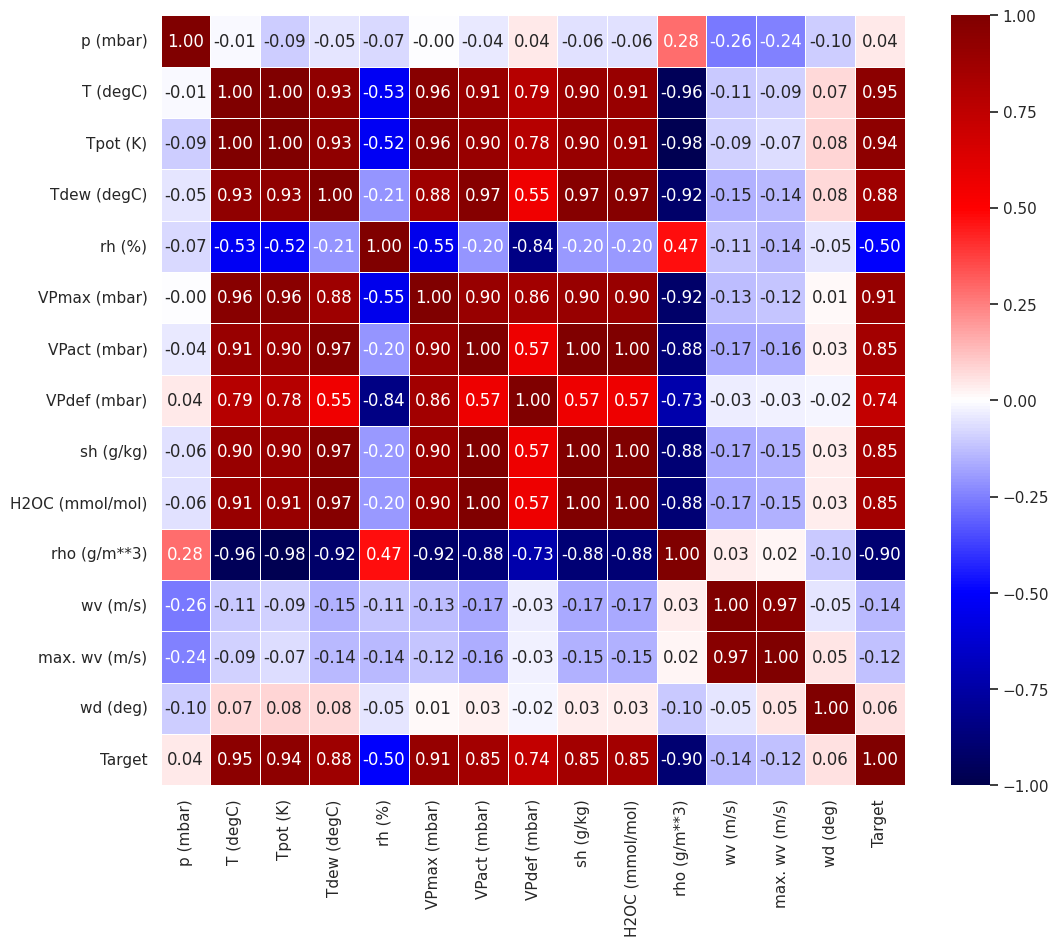

In [612]:
sns.set(rc = {'figure.figsize': (12, 10)})
corr = df_train.corr()
sns.heatmap(corr, linewidth = 0.5, cmap = "seismic", vmin = -1, vmax = 1, fmt = '.2f', annot = True)
plt.show(block = True)

**Вывод** целевой признак очень хорошо кореллирует с h2OC, sh, ..., VPmax, а также с Tdew, Tpot. Но тут проблема в том, что сами эти признаки имеют очень сильную попарную корреляцию. Поэтому все их использовать для предсказания - вредно!

Далее мы попробуем выкидывать по одному эти признаки и смотреть на результат!

Реализуем основные метрики для оченки результатов:

In [613]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def median_absolute_error(y_true, y_pred):
    return np.median(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    residual = np.sum(np.square(y_true - y_pred))
    total = np.sum(np.square(y_true - np.mean(y_true)))
    r2 = 1 - residual / total
    return r2

def print_metrics(y_true, y_pred):
    print(f'MSE : ',  mean_squared_error(y_true, y_pred))
    print(f'MAE : ',  mean_absolute_error(y_true, y_pred))
    print(f'MAPE : ', mean_absolute_percentage_error(y_true, y_pred))
    print(f'MedAE : ', median_absolute_error(y_true, y_pred))
    print(f'R^2 : ', r2(y_true, y_pred))

## Теперь будем создавать фичи и обучать модели!

Из Weather1.0 мы помним, что линейная регрессия дает очень хорошие результаты, что можно добавить немного фичей со скользащим окном в 7 дней:

In [614]:
df_train.drop(columns = ['Target'], inplace = True)
df_test.drop(columns = ['Target'], inplace = True)

In [615]:
window_size = 7
for col in df_train.columns:
    df_train[f'{col}_wmean'] = df_train[col].rolling(window = window_size, min_periods = 1).mean()
    df_train[f'{col}_wmedian'] = df_train[col].rolling(window = window_size, min_periods = 1).median()
    df_train[f'{col}_wmin'] = df_train[col].rolling(window = window_size, min_periods = 1).min()
    df_train[f'{col}_wmax'] = df_train[col].rolling(window = window_size, min_periods = 1).max()

    df_test[f'{col}_wmean'] = df_test[col].rolling(window = window_size, min_periods = 1).mean()
    df_test[f'{col}_wmedian'] = df_test[col].rolling(window = window_size, min_periods = 1).median()
    df_test[f'{col}_wmin'] = df_test[col].rolling(window = window_size, min_periods = 1).min()
    df_test[f'{col}_wmax'] = df_test[col].rolling(window = window_size, min_periods = 1).max()

In [616]:
model = LinearRegression()
model.fit(df_train, target_train)

LinearRegression()

In [617]:
sorted_columns = []

for col, coef in sorted(zip(df_train.columns, model.coef_.squeeze()), key = lambda x: abs(x[1])):
    sorted_columns.append(col)
    print(f'{col} : {coef:5f}')

wd (deg)_wmin : -0.000860
wd (deg)_wmax : -0.001448
wd (deg) : 0.001576
VPmax (mbar)_wmedian : -0.001816
wd (deg)_wmean : 0.004633
wd (deg)_wmedian : -0.004754
rh (%)_wmedian : 0.007598
p (mbar)_wmedian : -0.009027
rho (g/m**3)_wmedian : -0.009499
p (mbar)_wmin : 0.011632
rho (g/m**3)_wmin : 0.015078
p (mbar) : 0.015585
p (mbar)_wmax : 0.018253
rho (g/m**3)_wmax : 0.019304
sh (g/kg)_wmin : 0.019933
rh (%)_wmax : -0.021380
rh (%)_wmin : -0.023920
VPdef (mbar) : -0.029243
rh (%) : 0.050258
rho (g/m**3)_wmean : -0.055704
T (degC)_wmin : -0.059291
Tdew (degC)_wmax : 0.068561
wv (m/s)_wmedian : -0.089128
rho (g/m**3) : -0.091089
rh (%)_wmean : -0.092191
VPdef (mbar)_wmedian : -0.099234
Tpot (K)_wmin : 0.102782
H2OC (mmol/mol)_wmin : 0.116596
T (degC)_wmax : 0.119685
sh (g/kg)_wmax : -0.121594
Tpot (K)_wmax : -0.124284
VPact (mbar)_wmin : -0.127833
p (mbar)_wmean : -0.144702
VPmax (mbar)_wmin : 0.152359
VPmax (mbar)_wmax : 0.153675
VPdef (mbar)_wmax : -0.155589
Tpot (K)_wmedian : -0.159973
V

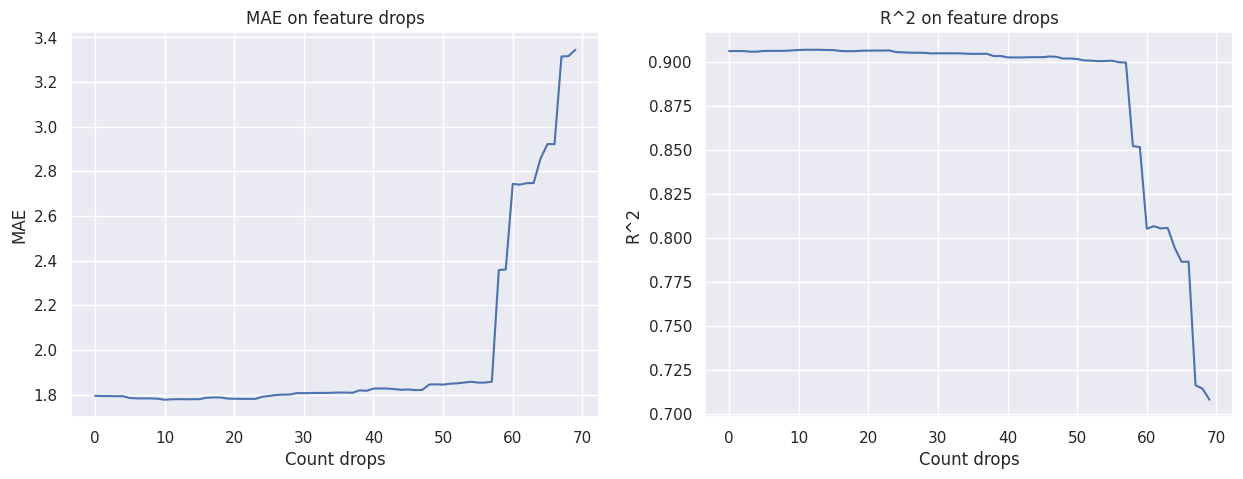

In [618]:
mae_history = []
r2_history = []

for i in range(len(sorted_columns)):
    
    drop_cols = sorted_columns[ :i]
    model = LinearRegression()
    model.fit(df_train.drop(columns = drop_cols), target_train)
    y_pred = model.predict(df_test.drop(columns = drop_cols))
    mae_history.append(mean_absolute_error(target_test.values, y_pred))
    r2_history.append(r2(target_test.values, y_pred))
            

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.title('MAE on feature drops')
plt.plot(np.linspace(0, len(sorted_columns) - 1, len(sorted_columns)), mae_history)
plt.xlabel('Count drops')
plt.ylabel('MAE')

plt.subplot(1, 2, 2)
plt.title('R^2 on feature drops')
plt.plot(np.linspace(0, len(sorted_columns) - 1, len(sorted_columns)), r2_history);
plt.xlabel('Count drops')
plt.ylabel('R^2');

In [619]:
pd.DataFrame({'MAE' : mae_history, 'R^2' : r2_history}).head(35)

,MAE,R^2
0,1.795064,0.906344
1,1.793713,0.906380
2,1.794060,0.906362
3,1.793117,0.906032
4,1.793382,0.906019
5,1.785187,0.906435
6,1.783453,0.906450
7,1.783508,0.906454
8,1.783317,0.906489
9,1.782274,0.906728


In [620]:
min(mae_history), max(r2_history)

(1.7774077186453006, 0.9071045958961758)

Видим, что если выкинем первые 10 фичу, то качество будет наилучшим для такого набора:

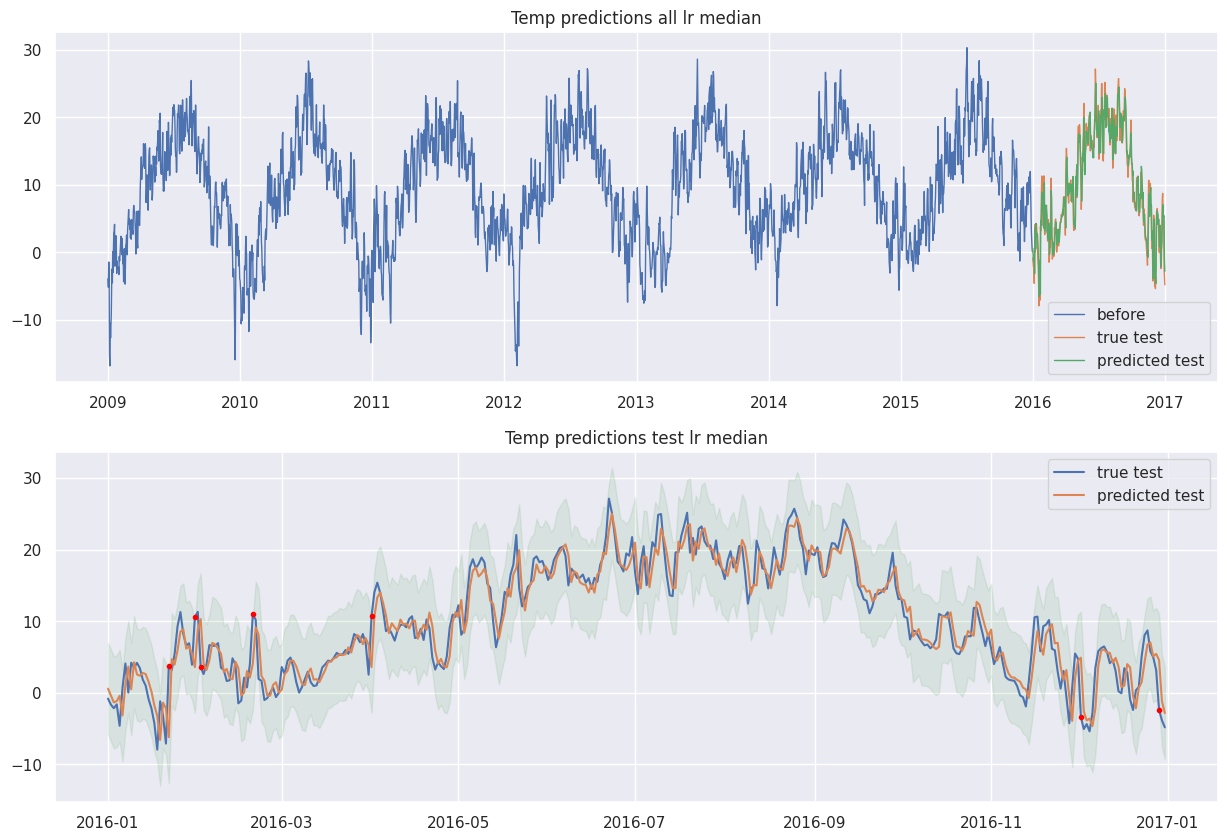

In [621]:
drop_cols = sorted_columns[ :11]

model = LinearRegression()
model.fit(df_train.drop(columns = drop_cols), target_train)
y_pred = model.predict(df_test.drop(columns = drop_cols))

plot_predictions(df_train, df_test, target_train, target_test, y_pred, plot_intervals=True, annot='lr median', plot_anomalies=True)

In [624]:
add_results_in_comparison_table('linreg drops best', target_test.values, y_pred)

,method,MSE,MAE,MAPE,Median_error,R^2
0,linreg drops best,5.595667,1.779331,110.809294,1.393292,0.907105


In [625]:
df_train_1 = df_train.drop(columns = drop_cols)
df_test_1 = df_test.drop(columns = drop_cols)

In [626]:
import scipy.stats as sps

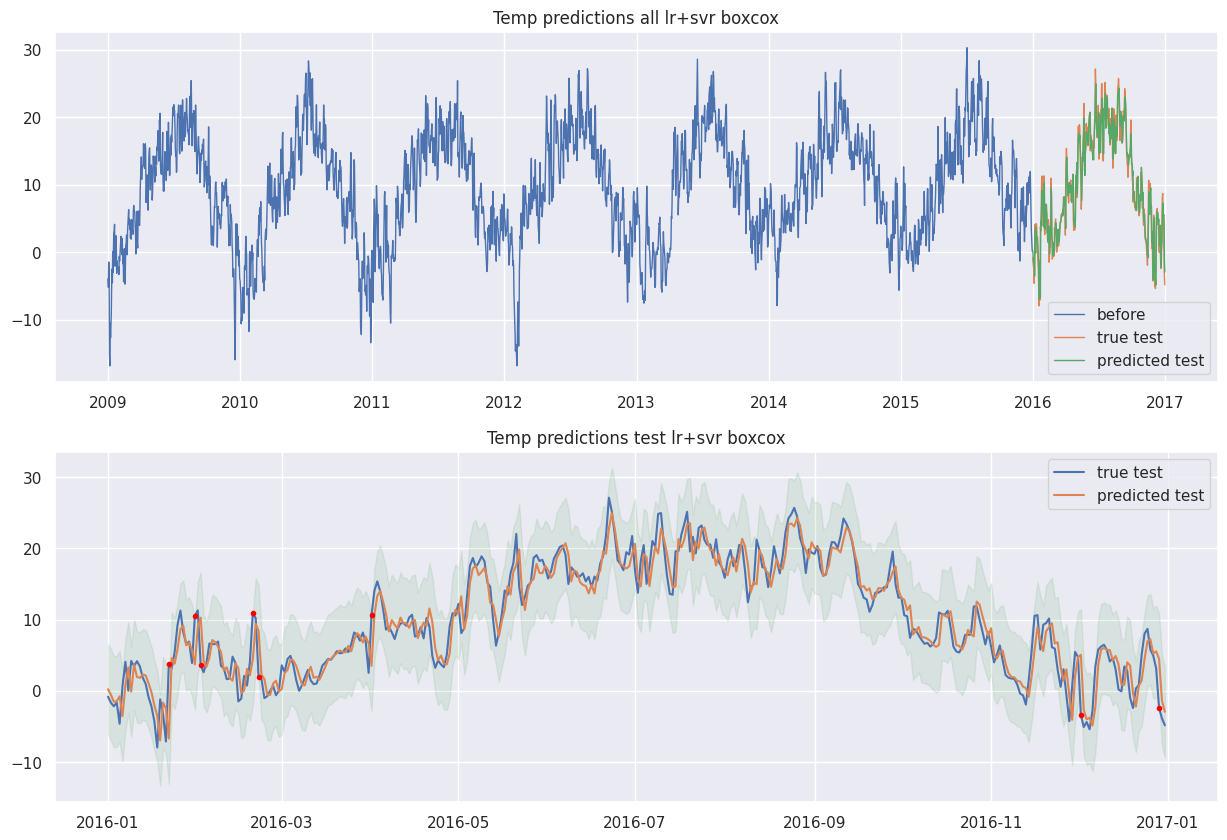

In [627]:
model = LinearRegression()

scaler = StandardScaler()
X_train = scaler.fit_transform(df_train_1)
X_test = scaler.transform(df_test_1)

model.fit(X_train, target_train)
y_fit = model.predict(X_train)
y_pred = model.predict(X_test)

X_train_boxcox = np.array([
    sps.boxcox((X_train - X_train.min(axis = 0) + 0.001)[:, i])[0] for i in range(X_train.shape[1])
]).T
X_test_boxcox = np.array([
    sps.boxcox((X_test - X_test.min(axis = 0) + 0.001)[:, i])[0] for i in range(X_test.shape[1])
]).T

model_res = SVR(
    C = 0.5,
    epsilon = 1.2
)
model_res.fit(X_train_boxcox, target_train - y_fit)
y_pred += model_res.predict(X_test_boxcox).reshape(-1, 1)

plot_predictions(df_train, df_test, target_train, target_test, y_pred, plot_intervals=True, annot='lr+svr boxcox', plot_anomalies=True)

In [628]:
add_results_in_comparison_table('linreg+SVR boxcox', target_test.values, y_pred)

,method,MSE,MAE,MAPE,Median_error,R^2
0,linreg drops best,5.595667,1.779331,110.809294,1.393292,0.907105
1,linreg+SVR boxcox,5.573552,1.760453,107.530805,1.400377,0.907472


**Вывод:** Немного улучшили результат!

Посмотрим как тут распределены остатки:

In [629]:
def get_studentized_residuals(X, y_true, y_pred):
    H = X.dot(np.linalg.inv(X.T.dot(X))).dot(X.T)
    rss = ((y_true - y_pred)**2).sum()
    std = rss / (X.shape[0] - X.shape[1] - 1)
    e = (y_true - y_pred) / np.sqrt(std) / np.sqrt(1 - np.diag(H))
    return e

student_residuals = get_studentized_residuals(df_test_1.to_numpy(), target_test['Target'].to_numpy().squeeze(), y_pred.squeeze())

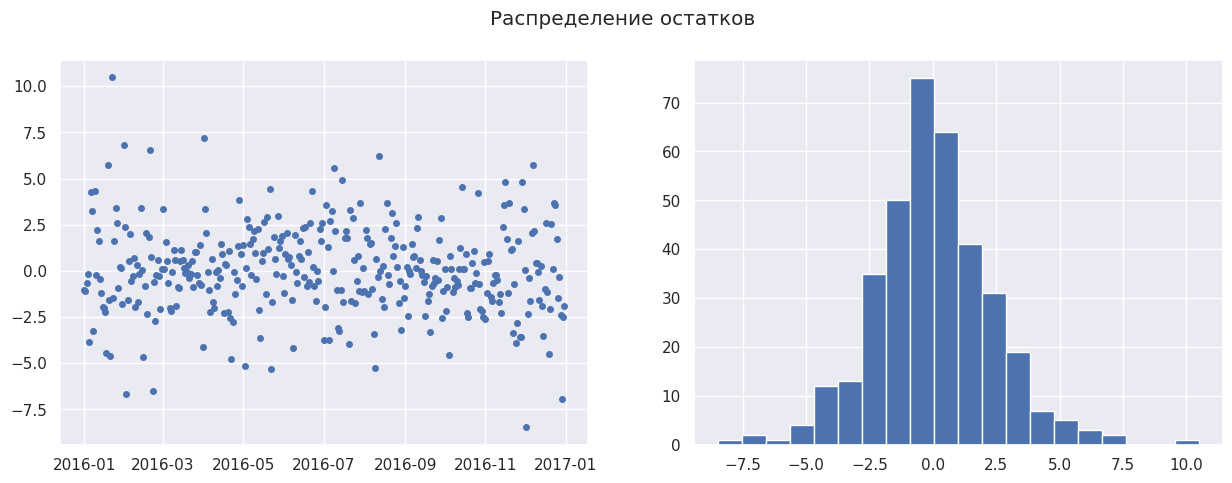

In [630]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(target_test - y_pred, 'o', markersize = 4);
plt.subplot(1, 2, 2)
plt.hist(target_test - y_pred, bins = 20)
plt.suptitle('Распределение остатков')
plt.show();

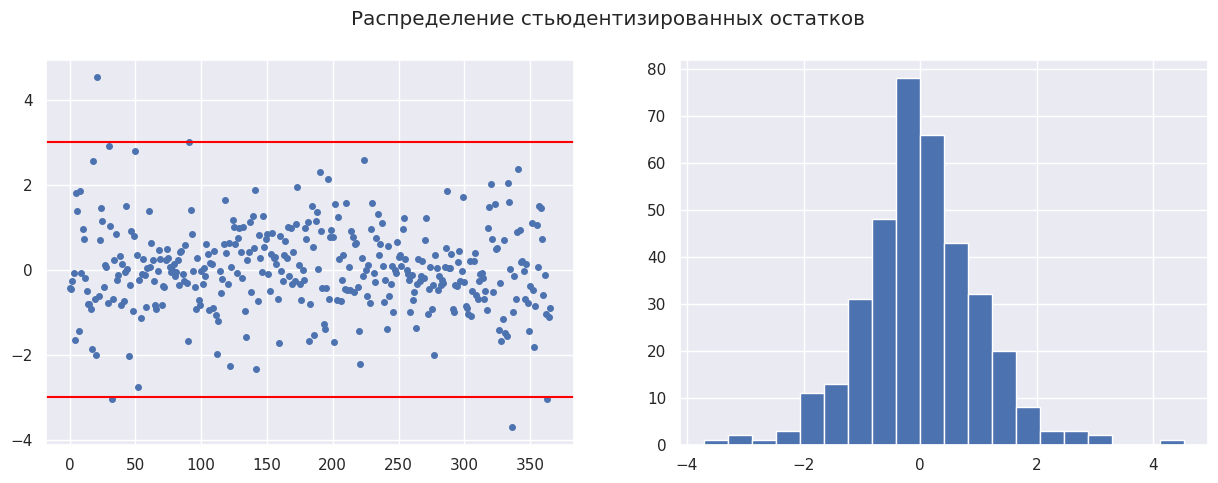

In [631]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(student_residuals, 'o', markersize = 4)
plt.axhline(y = -3, color = 'red')
plt.axhline(y = 3, color = 'red')
plt.subplot(1, 2, 2)
plt.hist(student_residuals, bins = 20)
plt.suptitle('Распределение стьюдентизированных остатков')
plt.show();

In [632]:
import scipy.stats as sps
print(f'D\'Agostino :',sps.normaltest(student_residuals))
print(f'Shapiro: ', sps.shapiro(student_residuals))

D'Agostino : NormaltestResult(statistic=18.542384607630282, pvalue=9.409625560568862e-05)
Shapiro:  ShapiroResult(statistic=0.9821375012397766, pvalue=0.0001678099943092093)


НЕ принимаем гипотезу о том, что остатки распределены нормально!

Теперь попробуем не удалять фичи последовательно, а выкинуть фичи, которые слабо корреллируют с таргетом:

In [633]:
def remove_low_corr_features(df, target_col, threshold):
    data = pd.concat([df, target_col], axis = 1)
    corr_matrix = data.corr().abs()
    corrs_with_target = corr_matrix.iloc[-1]
    features_to_drop = []
    for col, corr in zip(corrs_with_target.index, corrs_with_target):
        if corr < threshold: 
            features_to_drop.append(col)

    return features_to_drop

In [634]:
drop_low_corr = remove_low_corr_features(df_train, target_train, threshold = 0.2)

In [635]:
df_train_2 = df_train.drop(columns = drop_low_corr)
df_test_2 = df_test.drop(columns = drop_low_corr)

In [636]:
model = LinearRegression()

scaler = StandardScaler()
X_train = scaler.fit_transform(df_train_2)
X_test = scaler.transform(df_test_2)

model.fit(X_train, target_train)
model.coef_

array([[ 1.32991170e+01, -5.66269036e+00, -2.70584890e+00,
         8.39516489e-01, -1.27526894e+00,  4.76916147e+01,
         4.88213566e-02,  2.02557879e+01, -6.74404753e+01,
        -2.73108442e+00,  3.80446676e-02,  8.29709570e+00,
         1.62713644e+00, -5.74209900e-01,  1.25489744e+00,
        -1.74732652e+01, -1.22612920e+00,  1.37970911e+00,
        -1.07673771e+00, -1.79764321e+00,  1.93017512e+00,
         9.17547393e-01,  1.76836736e-01, -9.04484785e-01,
         6.73006804e-02, -3.06581264e-01, -2.20161560e-01,
         3.14509224e+00, -9.17717465e-02,  6.14940189e-01,
         9.60199211e-01, -1.60217285e+01, -7.45937322e+00,
         6.49521419e-02, -9.89770446e+00, -6.02326233e-01,
        -2.70467860e-01, -4.14941773e-01, -6.08424059e-01,
        -2.28353113e+02,  4.96363020e+01, -2.80303631e+00,
        -5.15411769e+00,  2.43425436e+02, -4.31378568e+01,
         3.06162405e+00,  1.59865677e+01, -5.29117819e+00,
        -4.10454439e-01,  3.93113401e-01,  8.31226398e-0

Видим, что коэффициенты уже не такие маленькие!

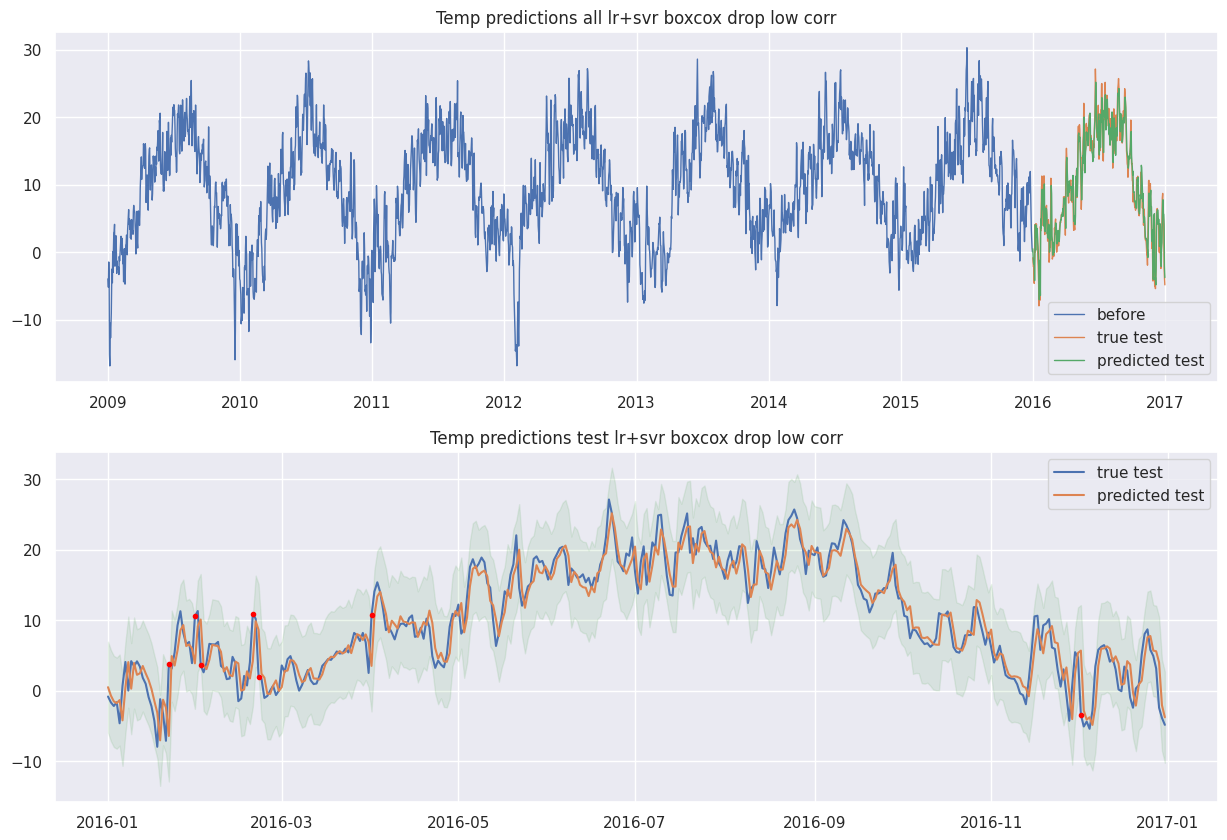

In [637]:
y_fit = model.predict(X_train)
y_pred = model.predict(X_test)

X_train_boxcox = np.array([
    sps.boxcox((X_train - X_train.min(axis = 0) + 0.001)[:, i])[0] for i in range(X_train.shape[1])
]).T
X_test_boxcox = np.array([
    sps.boxcox((X_test - X_test.min(axis = 0) + 0.001)[:, i])[0] for i in range(X_test.shape[1])
]).T

model_res = SVR(
    C = 0.5,
    epsilon = 1.2
)
model_res.fit(X_train_boxcox, target_train - y_fit)
y_pred += model_res.predict(X_test_boxcox).reshape(-1, 1)

plot_predictions(df_train, df_test, target_train, target_test, y_pred, plot_intervals=True, annot='lr+svr boxcox drop low corr', plot_anomalies=True)

In [638]:
add_results_in_comparison_table('lr+svr boxcox drop low corr', target_test.values, y_pred)

,method,MSE,MAE,MAPE,Median_error,R^2
0,linreg drops best,5.595667,1.779331,110.809294,1.393292,0.907105
1,linreg+SVR boxcox,5.573552,1.760453,107.530805,1.400377,0.907472
2,lr+svr boxcox drop low corr,5.676283,1.788125,113.926142,1.376364,0.905766


Результат улучшить не удалось...